# Near-Surface Air Temperature
conda env: new `phd_v3`, old `work` (in `envs/phd`)

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


In [4]:
# from dask.distributed import Client
# client = Client()
# client

In [5]:
# client.close()

## Set variables

In [2]:
period = slice('1979','2014')
latlim, lonlim = u.get_domain_HMA()
seasons = ['Annual', 'DJFMA', 'JJAS']
# seasons = ['Annual']

# Make a extended version for regridding properly on the edges
latlim_ext, lonlim_ext = slice(latlim.start-5, latlim.stop+5), slice(lonlim.start-5, lonlim.stop+5)

# Get zone limits for annual cycle
lonlim_HK, latlim_HK, lonlim_HM, latlim_HM, lonlim_TP, latlim_TP = u.get_zones()

# HMA for full domain and the following for the above zones
zones = ['HMA', 'HK', 'HM', 'TP']
zones_df = pd.DataFrame(
    [[lonlim, latlim], [lonlim_HK, latlim_HK], [lonlim_HM, latlim_HM], [lonlim_TP, latlim_TP]], 
    columns=pd.Index(['lonlim', 'latlim'], name='Limits'),
    index=pd.Index(zones, name='Zones')
)

var = 'tas'
table = u.get_table(var)
label, units, levels, cmap, extend, \
    levels_diff, cmap_diff, extend_diff, \
    levels_bias, cmap_bias, extend_bias = u.get_var_infos(var)
label

'Near-Surface Air Temperature'

## Load topography

In [3]:
ds = xr.open_dataset('GMTED2010_15n240_1000deg.nc').drop_dims('nbounds').swap_dims(
    {'nlat': 'latitude', 'nlon': 'longitude'}).drop({'nlat', 'nlon'}).rename(
    {'latitude': 'lat', 'longitude': 'lon'}).sel(lat=latlim_ext, lon=lonlim_ext)
elevation = ds.elevation
elevation_std = ds.elevation_stddev

## Load obs
cru_ts4.00: https://crudata.uea.ac.uk/cru/data/hrg/

In [4]:
obs_longname = 'CRU TS v. 4.00'
obs_name = 'CRU'

obs = xr.open_dataset('/bdd/cru/cru_ts_4.00/data/tmp/cru_ts4.00.1901.2015.tmp.dat.nc').sel(
    time=period, lat=latlim_ext, lon=lonlim_ext).tmp

# Check if the time steps are ok
np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, obs.time.size)

temp = []
for season in seasons:
    temp.append(
        u.clim(obs, calendar=obs.time.encoding['calendar'], season=season)
    )

# Compute climatology and annual cycle
obs_clim = xr.combine_nested(temp, concat_dim='season')
obs_ac = u.annual_cycle(obs, calendar=obs.time.encoding['calendar'])

In [5]:
# obs_clim[2].plot()
# obs_ac
# u.spatial_average(obs_ac).plot()

## Regrid obs towards the elevation grid of 1°x1°
Using xESMF (https://xesmf.readthedocs.io/en/latest/)

In [5]:
regridder = xe.Regridder(obs_clim, elevation, 'bilinear', periodic=False, reuse_weights=True)
obs_clim_regrid = regridder(obs_clim)
obs_clim_regrid.attrs['long_name'] = 'Air Temperature'
obs_clim_regrid.attrs['units'] = units

# Compute annual cycle for each zones
temp = [None]*len(zones)
obs_ac_regrid = regridder(obs_ac)
for i, zone in enumerate(zones):
    temp[i] = u.spatial_average(
        obs_ac_regrid.sel(lat=zones_df.latlim[zone], lon=zones_df.lonlim[zone]).where(elevation > 2500)
    )

obs_ac_regrid_zones = xr.concat(temp, pd.Index(zones, name="zone")).load()

Reuse existing file: bilinear_70x120_35x60.nc


[#Load-results](#Load-results)

## Load models

In [9]:
list_models = u.get_model_names()
# list_models = list_models[:1]
# list_models = ['EC-Earth3']

# Create empty lists for storing results before to concatenate them (for models + ensemble mean and seasons)
# Be carefull with *, see https://snakify.org/fr/lessons/two_dimensional_lists_arrays/#section_2
resolution = [None]*(len(list_models)+1)
annual_cycle = [[None] * (len(list_models)) for i in range(len(zones))]
bias = [[None] * (len(list_models)+1) for i in range(len(seasons))]
rmse = [[None] * (len(list_models)+1) for i in range(len(seasons))]
mb = [[None] * (len(list_models)+1) for i in range(len(seasons))]

for i, model in enumerate(list_models):
    print(model + ' ('+str(i+1)+'/'+str(len(list_models))+')')
    institute, grid, realization, calendar = u.get_model_infos(model, var)
    ds = xr.open_mfdataset(
        '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/'+var+'/'+grid+'/latest/*.nc', 
        combine='by_coords').sel(time=period, lat=latlim_ext, lon=lonlim_ext)[var]
    
    # Check if the time steps are ok
    np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, ds.time.size)
    
    # tas (K -> °C)
    #################################################################################
    
    ds -= 273.15
        
    #################################################################################
    
    # Print resolution and save it
    lat = (ds.lat[1] - ds.lat[0]).values; lon = (ds.lon[1] - ds.lon[0]).values
    print(str(lon.round(3))+'°x'+str(lat.round(3))+'°')
    resolution[i] = str(lon.round(1))+'°x'+str(lat.round(1))+'°'
    
    # Make regridder
    regridder = xe.Regridder(ds, elevation, 'bilinear', periodic=False, reuse_weights=True)
    
    # Compute annual cycle for all HMA domain (>2500m) + zones
    ac = u.annual_cycle(ds, calendar=calendar)
    ac_regrid = regridder(ac)
    for z, zone in enumerate(zones):
        annual_cycle[z][i] = u.spatial_average(
            ac_regrid.sel(lat=zones_df.latlim[zone], lon=zones_df.lonlim[zone]).where(elevation > 2500)
        )
    
    # Compute metrics on the only HMA zone
    for k, season in enumerate(seasons):
#         print(season)
        
        # Compute climatology
        model_clim = u.clim(ds, calendar=calendar, season=season)

        # Regrid towards elevation grid 1°x1°
        model_clim_regrid = regridder(model_clim)

        # Compute the bias (k for season, i for model) on all domain
        bias[k][i] = (model_clim_regrid - obs_clim_regrid.sel(season=season)).sel(lat=latlim, lon=lonlim).load()
        
        # Compute the pattern/spatial area-weighted RMSE and mean bias (for HMA > 2500 m)
        rmse[k][i] = np.sqrt(u.spatial_average(bias[k][i].where(elevation > 2500)**2))
        mb[k][i] = u.spatial_average(bias[k][i].where(elevation > 2500))
        
    print('\n')

BCC-CSM2-MR (1/27)
1.125°x1.121°
Reuse existing file: bilinear_32x54_35x60.nc


BCC-ESM1 (2/27)


KeyboardInterrupt: 

## Make multi-model ensemble and average for metrics

In [ ]:
# Index -1 is for mmm (Multi-Model Mean)

temp = [None] * len(seasons)
for k, season in enumerate(seasons):
    # Concatenate the multimodel ensemble (bias[k][:-1] not to take the last indice for mmm that is None)
    multimodel_ensemble_bias = xr.concat(
        bias[k][:-1], pd.Index(list_models, name="model"), coords='minimal', compat='override'
    )

    # Compute multimodel mean
    mmm_bias = multimodel_ensemble_bias.mean('model')
    
    # Add resolution
    resolution[-1] = '1°x1°'
    
    # Add the bias and metrics in position -1 (for mmm)
    bias[k][-1] = mmm_bias
    rmse[k][-1] = np.sqrt(u.spatial_average(mmm_bias.where(elevation > 2500)**2))
    mb[k][-1] = u.spatial_average(mmm_bias.where(elevation > 2500))

    list_models_mmm = list_models.copy()
    list_models_mmm.append('Multi-Model Mean')


    # Concatenate the mmm of the multimodel_ensemble_bias
    temp[k] = xr.concat(
        bias[k], pd.Index(list_models_mmm, name="model"), coords='minimal', compat='override'
    )

    # Add the rmse and mb as coordinates
    temp[k] = temp[k].assign_coords({
        'rmse': ('model', rmse[k]),
        'mean_bias': ('model', mb[k]),
        'resolution': ('model', resolution),
    })
    
    
# Concatenate the mmm of the multimodel_ensemble_bias
multimodel_ensemble_bias_mmm = xr.concat(temp, pd.Index(seasons, name="season"))

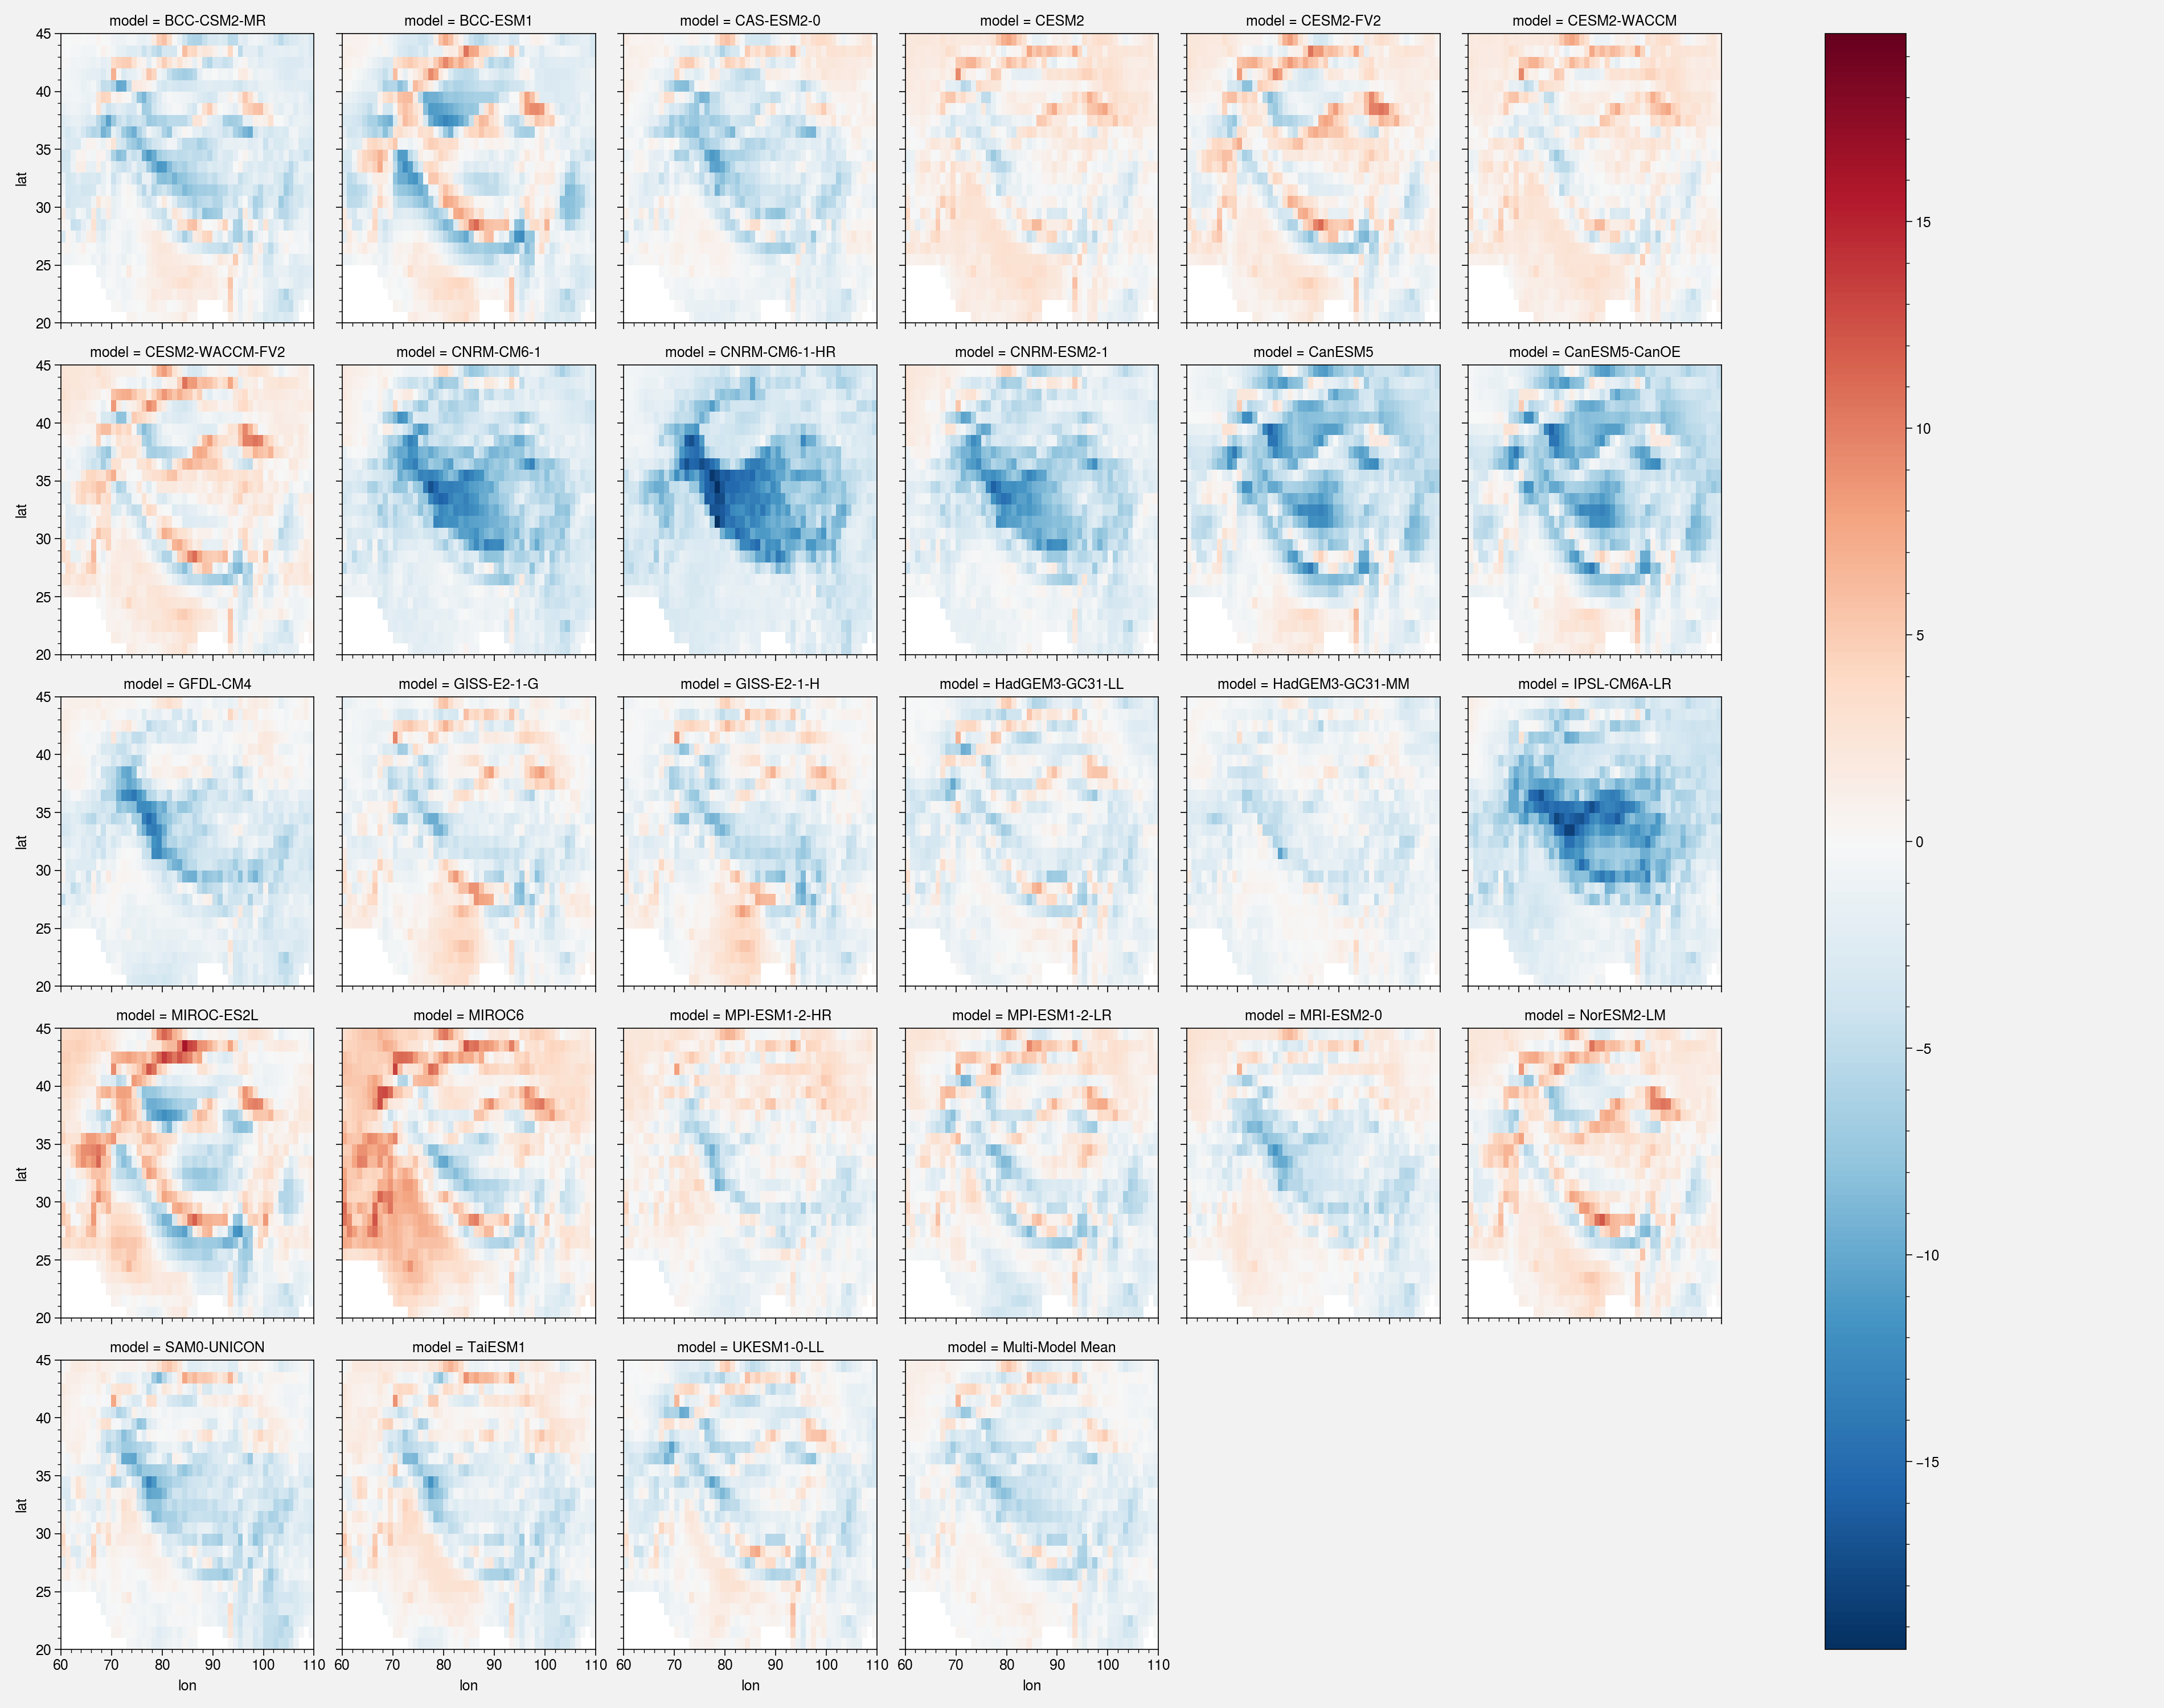

In [11]:
multimodel_ensemble_bias_mmm[0].plot(col='model', col_wrap=6)

## Concatenate annual cycle

In [12]:
temp = [None]*len(zones)

for i, zone in enumerate(zones):
    temp[i] = xr.concat(annual_cycle[i], pd.Index(list_models, name="model"), 
                        coords='minimal', compat='override')

multimodel_ensemble_ac = xr.concat(temp, pd.Index(zones, name="zone")).load()

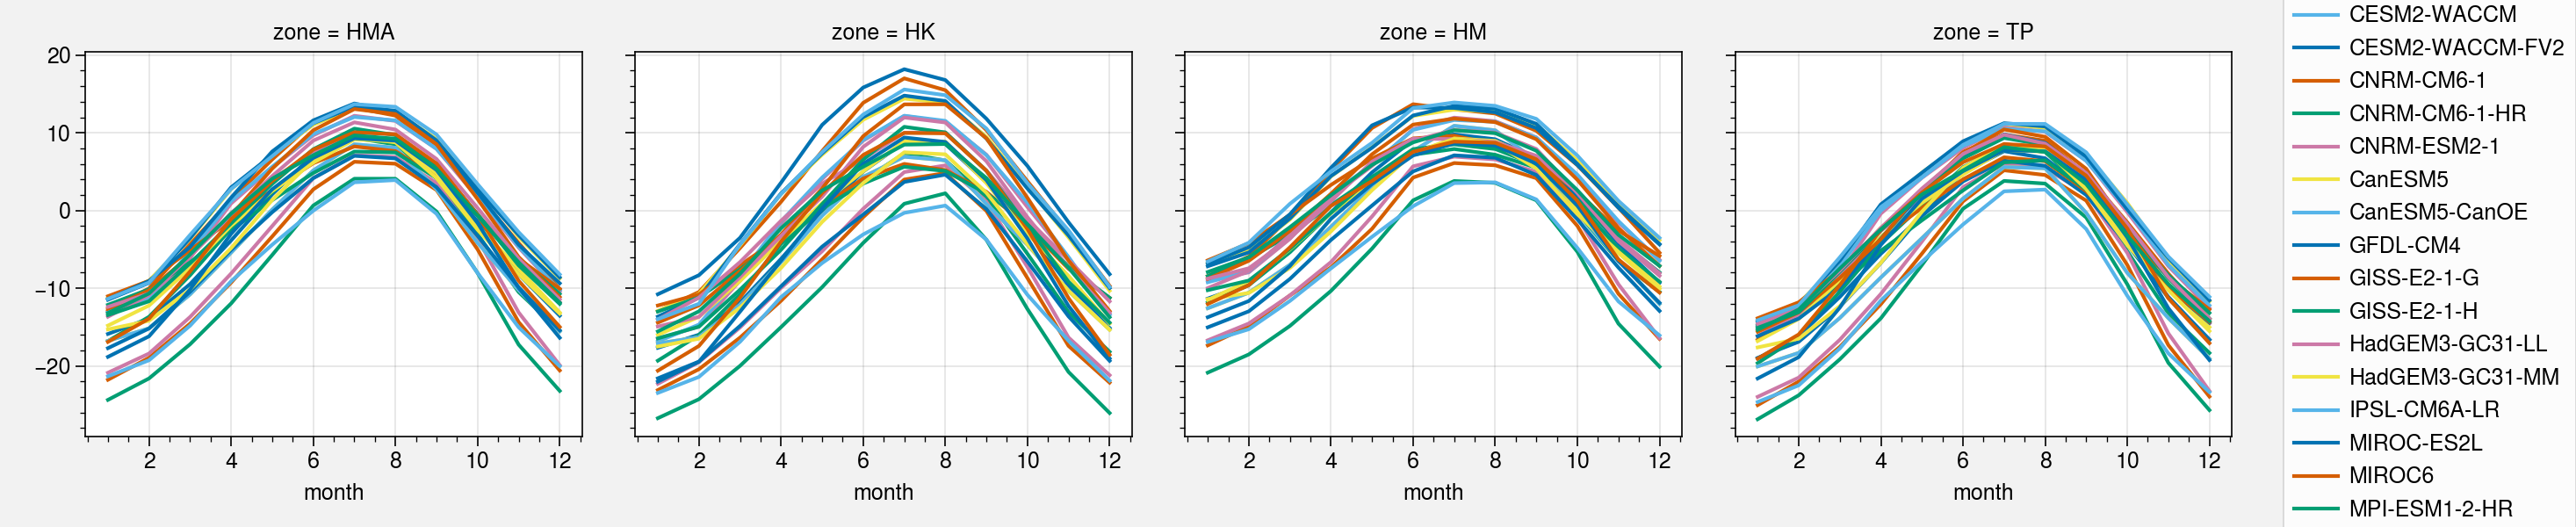

In [13]:
multimodel_ensemble_ac.plot(col='zone', hue='model', x='month')

## Save results

In [14]:
multimodel_ensemble_bias_mmm.attrs['long_name'] = label
multimodel_ensemble_bias_mmm.attrs['units'] = units
multimodel_ensemble_bias_mmm.attrs['period'] = period.start+'-'+period.stop

multimodel_ensemble_bias_mmm.to_netcdf(
    'results/'+var+'_'+period.start+'-'+period.stop+'multimodel_ensemble_bias_mmm.nc'
)


multimodel_ensemble_ac.attrs['long_name'] = label
multimodel_ensemble_ac.attrs['units'] = units
multimodel_ensemble_ac.attrs['period'] = period.start+'-'+period.stop

multimodel_ensemble_ac.to_netcdf(
    'results/'+var+'_'+period.start+'-'+period.stop+'multimodel_ensemble_ac.nc'
)

## Load results

In [6]:
# mmm: multimodel mean (is at the last index)
multimodel_ensemble_bias_mmm = xr.open_dataarray(
    'results/'+var+'_'+period.start+'-'+period.stop+'multimodel_ensemble_bias_mmm.nc'
)

multimodel_ensemble_ac = xr.open_dataarray(
    'results/'+var+'_'+period.start+'-'+period.stop+'multimodel_ensemble_ac.nc'
)

In [7]:
multimodel_ensemble_bias_mmm.model.size # with ensemble mean
# multimodel_ensemble_ac

28

# Bias
## Check min and max
### Model

In [11]:
for season in seasons:
    print(
        season,
        multimodel_ensemble_bias_mmm.sel(season=season).min().values, 
        multimodel_ensemble_bias_mmm.sel(season=season).max().values
    )

Annual -19.548299424096825 16.075162782861028
DJFMA -21.74959277715151 15.778501631151691
JJAS -18.40113143947756 18.967050614881273


In [12]:
multimodel_ensemble_bias_mmm.min().values, multimodel_ensemble_bias_mmm.max().values

(array(-21.74959278), array(18.96705061))

### Obs

In [13]:
for season in seasons:
    print(
        season,
        obs_clim_regrid.sel(season=season).min().values, 
        obs_clim_regrid.sel(season=season).max().values
    )

Annual -8.249703437902586 28.721085317380656
DJFMA -20.41296477826412 27.982576190091375
JJAS 2.0414049945883086 34.184758987578675


In [14]:
obs_clim_regrid.min().values, obs_clim_regrid.max().values

(array(-20.41296478), array(34.18475899))

## Make final plots (for each season)

In [15]:
# import warnings
# warnings.filterwarnings('ignore')

### Plots obs separetly

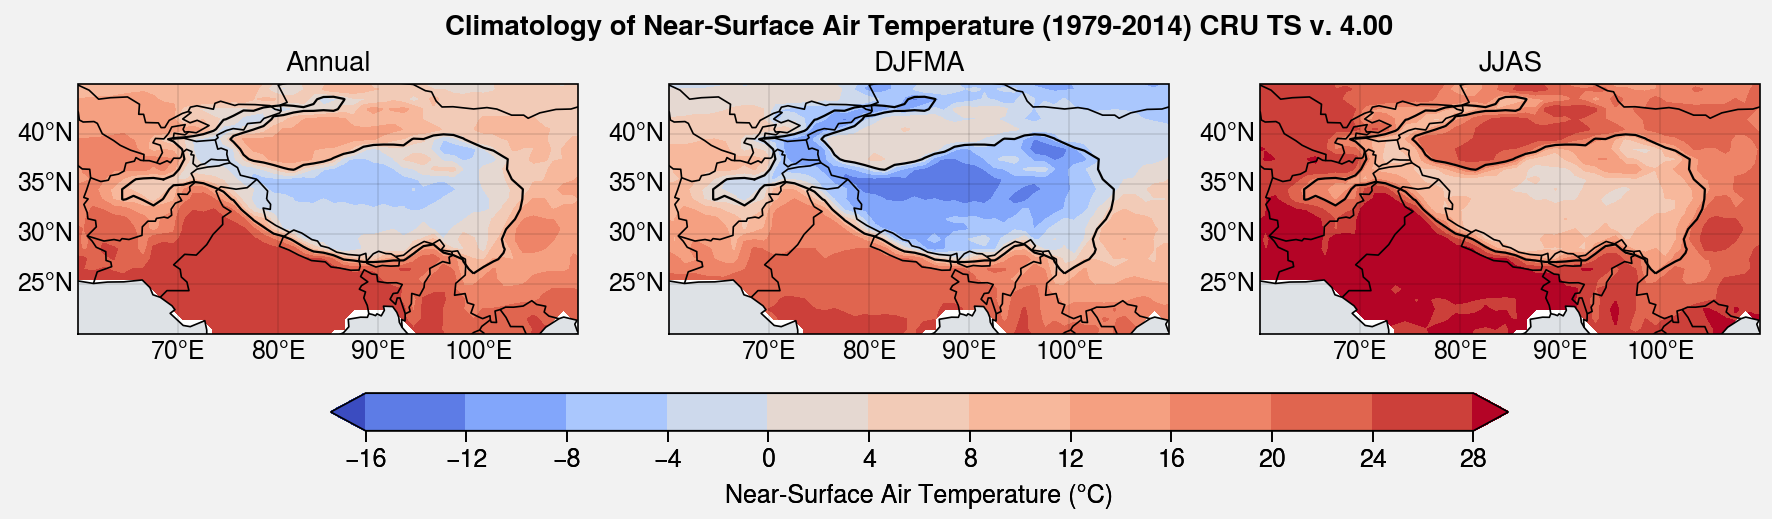

In [9]:
f, axs = plot.subplots(proj='cyl', ncols=3, nrows=1)

for i, ax in enumerate(axs):
    # Add contour 2500 m
    ax.contour(elevation, levels=[2500], color='black', linewidth=0.8)

    norm = plot.Norm('diverging', fair=False)
    
    # Plot observation
    m = ax.contourf(
        obs_clim_regrid.isel(season=i), cmap=cmap, 
        levels=plot.arange(-16,30,4), 
        extend='both', 
        norm=norm
    )
    ax.format(title=str(obs_clim_regrid.isel(season=i).season.values))


f.colorbar(m, label = label + ' ('+units+')', loc='b', length=0.7)

axs.format(
    # Grids, labels and limits
    labels=True, lonlines=10, latlines=5, 
    latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),

    # Add coast, ocean, borders
    coast=True, ocean=True, oceancolor='gray3', borders=True,

    # Suptitle
    suptitle='Climatology of '+label+' ('+period.start+'-'+period.stop+') ' + obs_longname  
)

filename = 'clim_obs_'+var+'_'+period.start+'-'+period.stop
# f.save('img/'+filename+'.jpg'); f.save('img/'+filename+'.png'); f.save('img/'+filename+'.pdf')

### Plot biases with multimodel at the end (and obs at the beginning if needed)

In [17]:
# multimodel_ensemble_bias_mmm.isel(season=2).plot(col='model', col_wrap=7, robust=True)

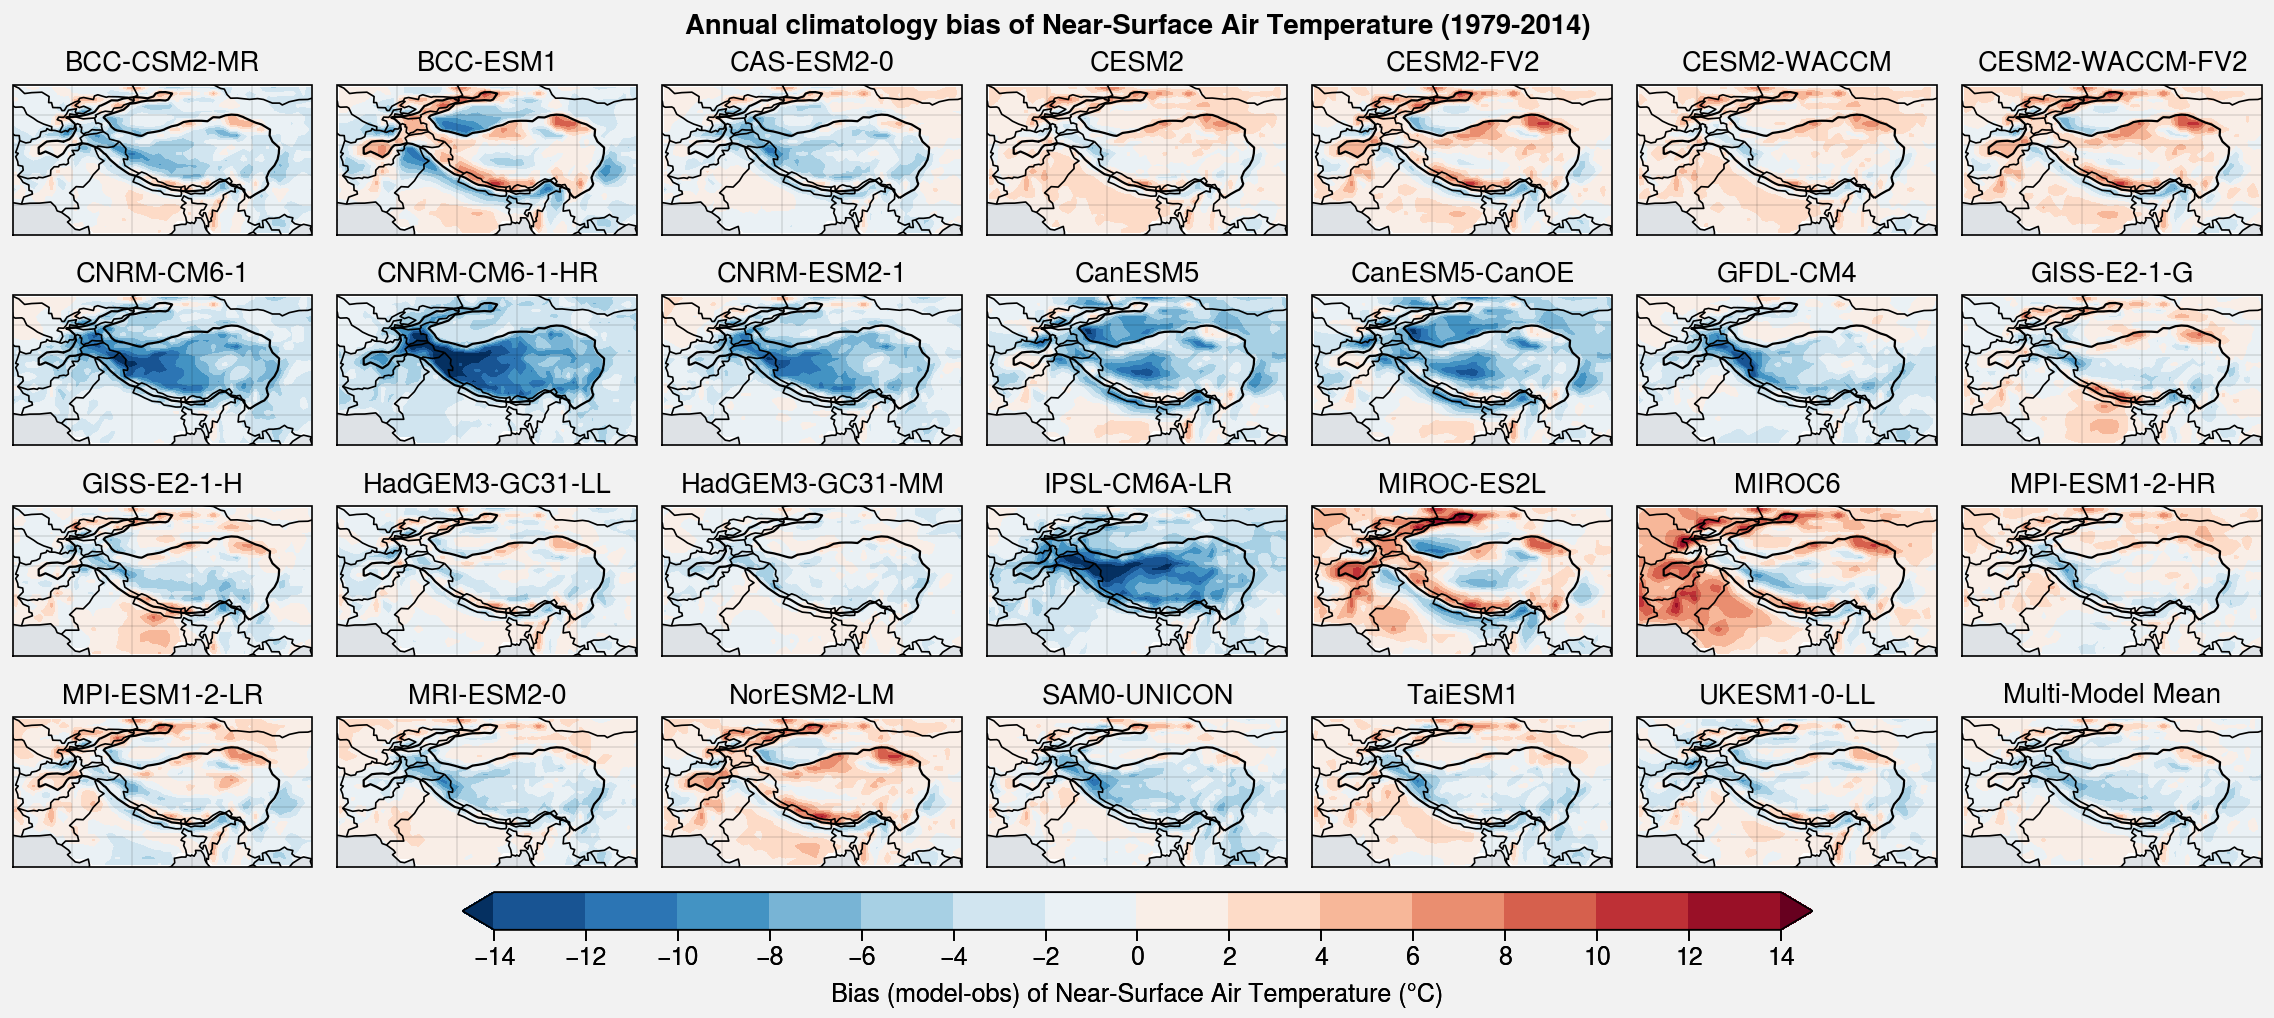

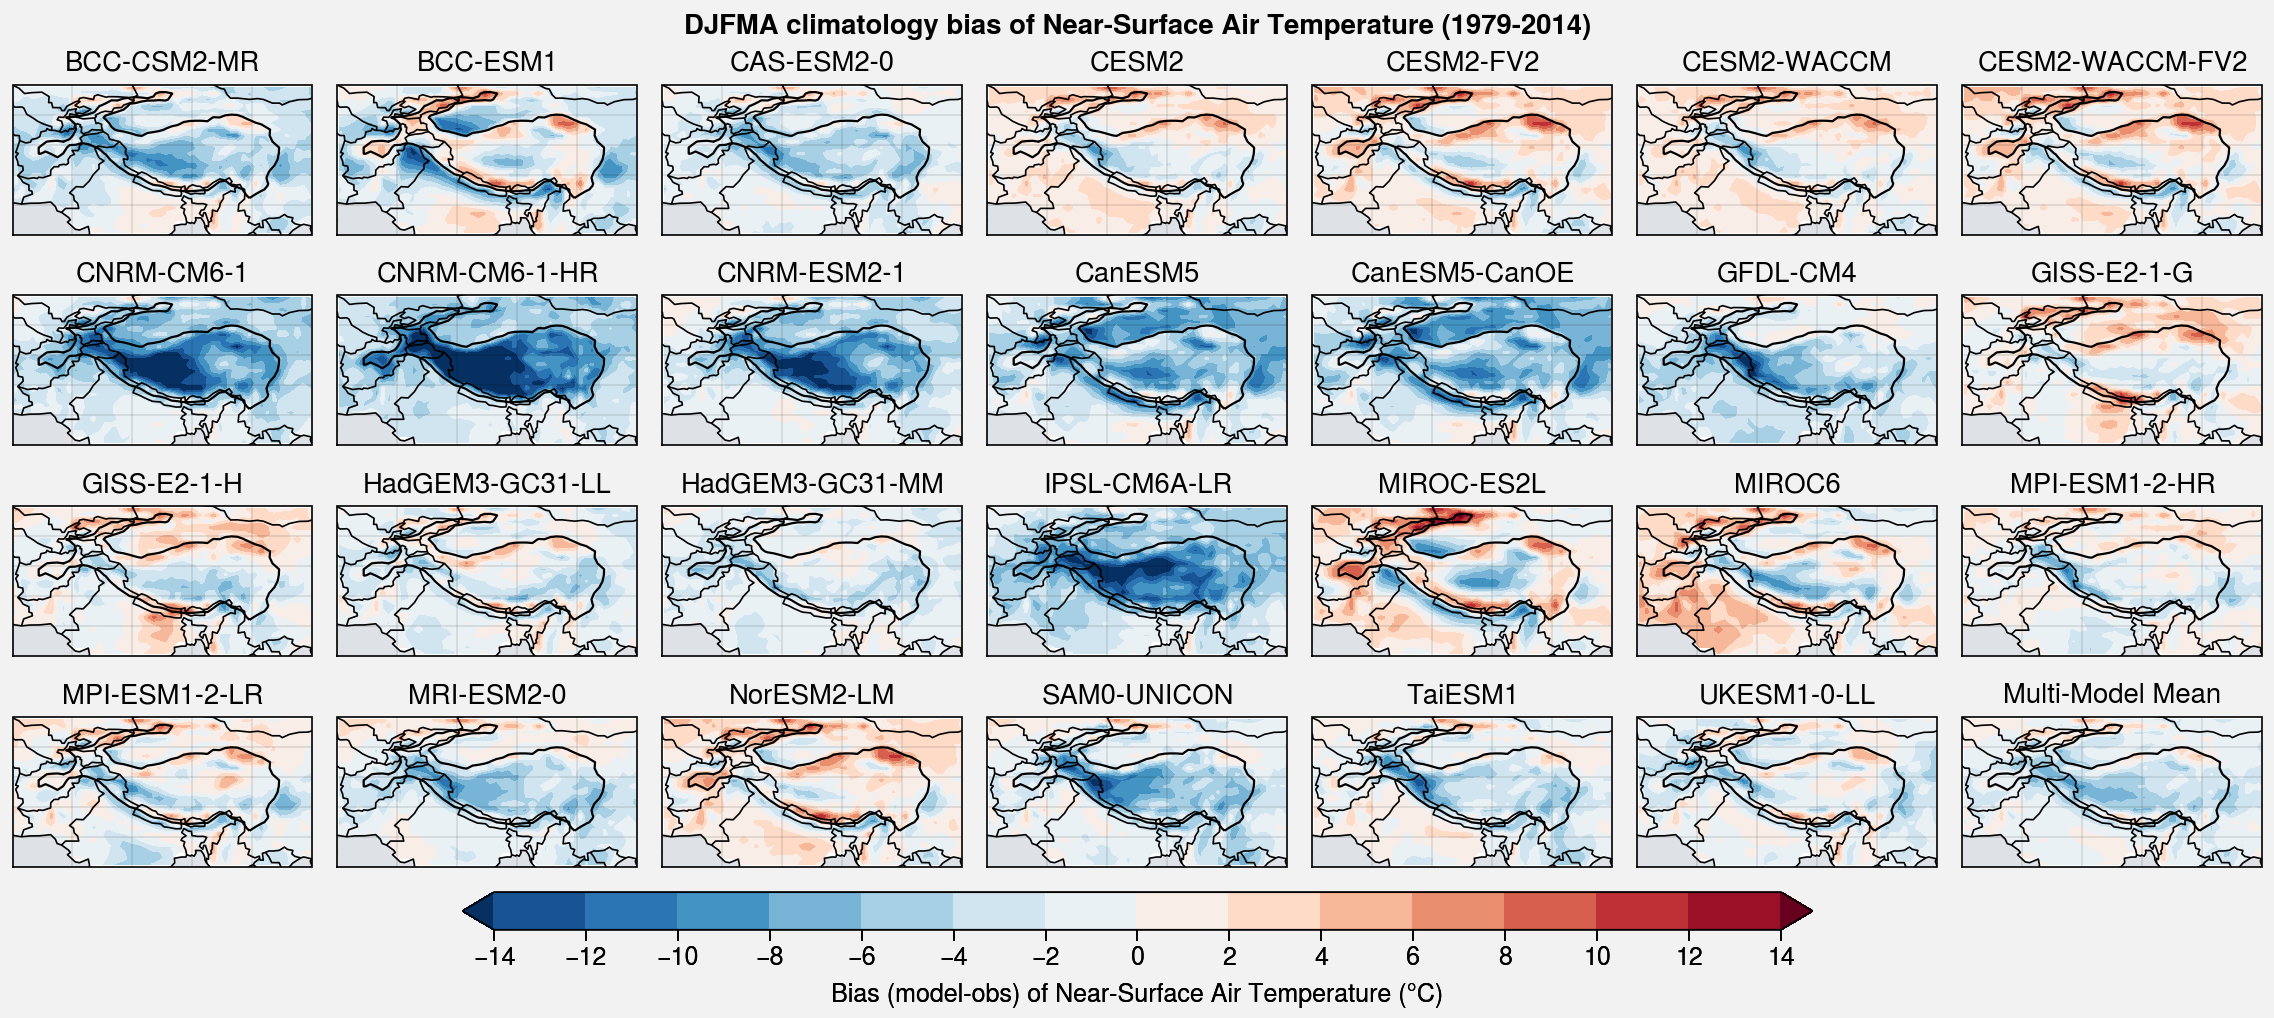

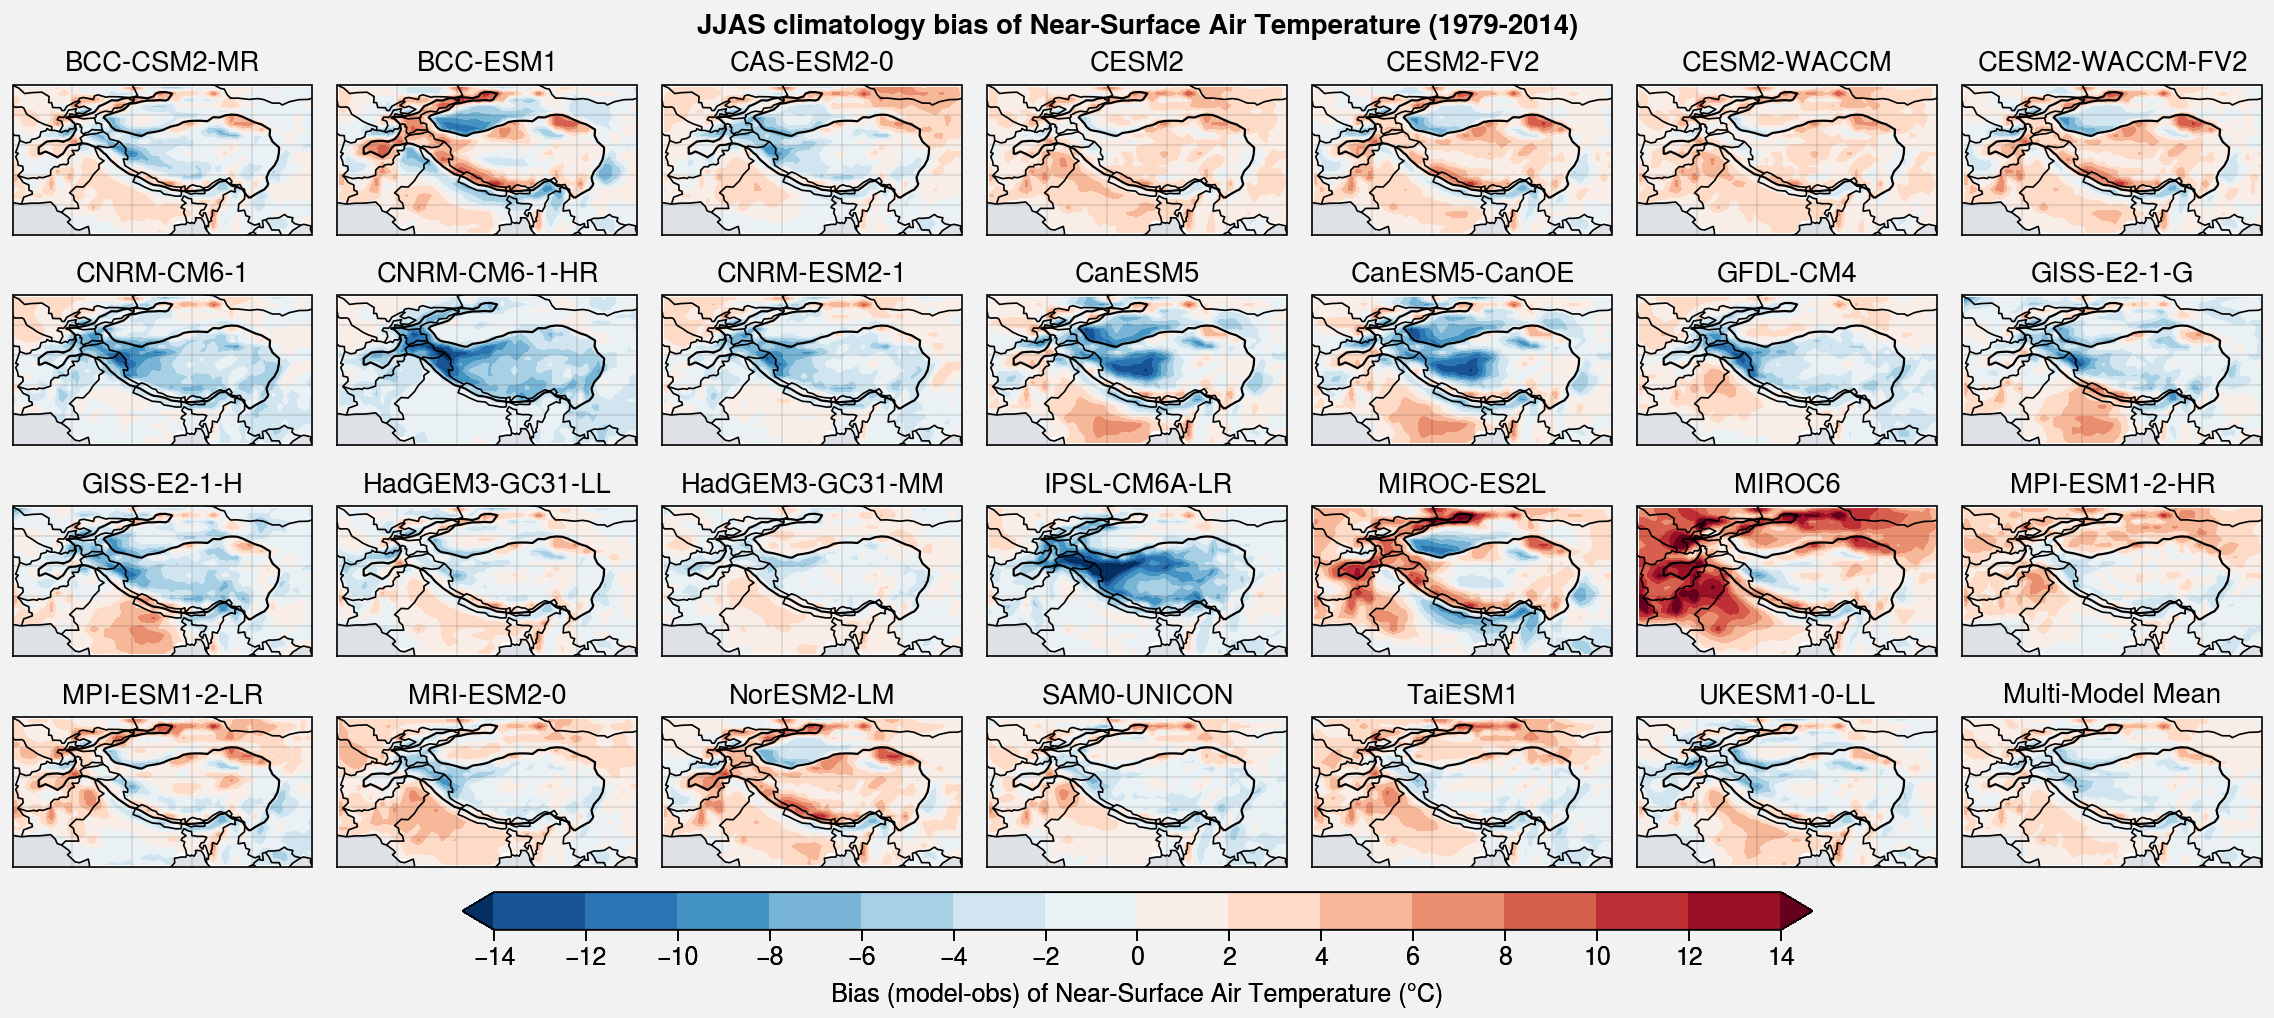

In [10]:
for season in seasons:
# for season in ['Annual']:
    f, axs = plot.subplots(proj='cyl', ncols=7, nrows=4, axwidth=1.5)
    
#     # Plot observation
#     ax = axs[0]
#     ax.contour(elevation, levels=[2500], color='black', linewidth=0.8)
#     ax.contourf(
#         obs_clim_regrid.sel(season=season), cmap=cmap, 
#         levels=plot.arange(-16,30,4), colorbar='l', extend='both', 
#         norm=plot.Norm('diverging', fair=False)
#     )
#     ax.format(title=obs_name)
    
    for i, ax in enumerate(axs[:]):
        # Add contour 2500 m
        ax.contour(elevation, levels=[2500], color='black', linewidth=0.8)

        # Plot model bias
        m = ax.contourf(
            multimodel_ensemble_bias_mmm.sel(season=season)[i], cmap='RdBu_r', 
            levels=plot.arange(-14,14,2), extend='both'
        ),

        # Text
        ax.format(title=str(multimodel_ensemble_bias_mmm.sel(season=season).model[i].values))

    f.colorbar(m, label='Bias (model-obs) of '+label+' ('+units+')', loc='b', length=0.6, extend='both')

    axs.format(
        # Grids, labels and limits
        labels=False, lonlines=10, latlines=5, 
        latlim=(latlim.start, latlim.stop), lonlim=(lonlim.start, lonlim.stop),
        
        # Add coast, ocean, borders
        coast=True, ocean=True, oceancolor='gray3', borders=True,
        
        # Suptitle
        suptitle=season+' climatology bias of '+label+' ('+period.start+'-'+period.stop+')'   
    )
    
    filename = season+'_clim_bias_'+var+'_'+period.start+'-'+period.stop
#     f.save('img/'+filename+'.jpg'); f.save('img/'+filename+'.png'); f.save('img/'+filename+'.pdf')

# Metrics

## Sorted by annual RMSE

In [9]:
# Data shape (season, model, metric)

list_data = [None]*len(seasons)

# Keep the multimodel mean separate ([:-1])
model_sorted_annual = multimodel_ensemble_bias_mmm.sel(season='Annual')[:-1].sortby(
#                       'rmse', ascending=False).model.values
                      'rmse', ascending=True).model.values
# model_sorted_annual = np.insert(model_sorted_annual, 0, multimodel_ensemble_bias_mmm.model[-1].values)
model_sorted_annual = np.append(model_sorted_annual, multimodel_ensemble_bias_mmm.model[-1].values)

for i, season in enumerate(seasons):
    data = np.ndarray(shape=(multimodel_ensemble_bias_mmm.model.size, 2))
    
#     data[:,0] = multimodel_ensemble_bias_mmm.sel(season=season).sortby('rmse', ascending=False).rmse
#     data[:,1] = multimodel_ensemble_bias_mmm.sel(season=season).sortby('rmse', ascending=False).mean_bias

    data[:,0] = multimodel_ensemble_bias_mmm.sel(season=season).reindex(model=model_sorted_annual).rmse
    data[:,1] = multimodel_ensemble_bias_mmm.sel(season=season).reindex(model=model_sorted_annual).mean_bias

    list_data[i] = pd.DataFrame(
        data, columns=pd.Index(['RMSE', 'Mean Bias'], name='Metric'),
        index=pd.Index(model_sorted_annual, name='Model')
    )

# data

In [12]:
for i, season in enumerate(seasons):
    print(season)
    print(list_data[i].min())
    print(list_data[i].max())
    print('\n')

Annual
Metric
RMSE         2.543751
Mean Bias   -9.807465
dtype: float64
Metric
RMSE         10.434725
Mean Bias     2.462924
dtype: float64


DJFMA
Metric
RMSE          3.257703
Mean Bias   -12.408575
dtype: float64
Metric
RMSE         13.052589
Mean Bias     1.448216
dtype: float64


JJAS
Metric
RMSE         2.377130
Mean Bias   -6.965473
dtype: float64
Metric
RMSE         8.214287
Mean Bias    3.273847
dtype: float64




In [13]:
multimodel_ensemble_bias_mmm.sel(season='Annual')[:-1].mean_bias.mean()

<xarray.DataArray 'mean_bias' ()>
array(-2.00906898)
Coordinates:
    height   float64 2.0
    season   <U6 'Annual'

In [15]:
multimodel_ensemble_bias_mmm.sel(season='Annual')[:-1].mean_bias.std()

<xarray.DataArray 'mean_bias' ()>
array(3.21239303)
Coordinates:
    height   float64 2.0
    season   <U6 'Annual'

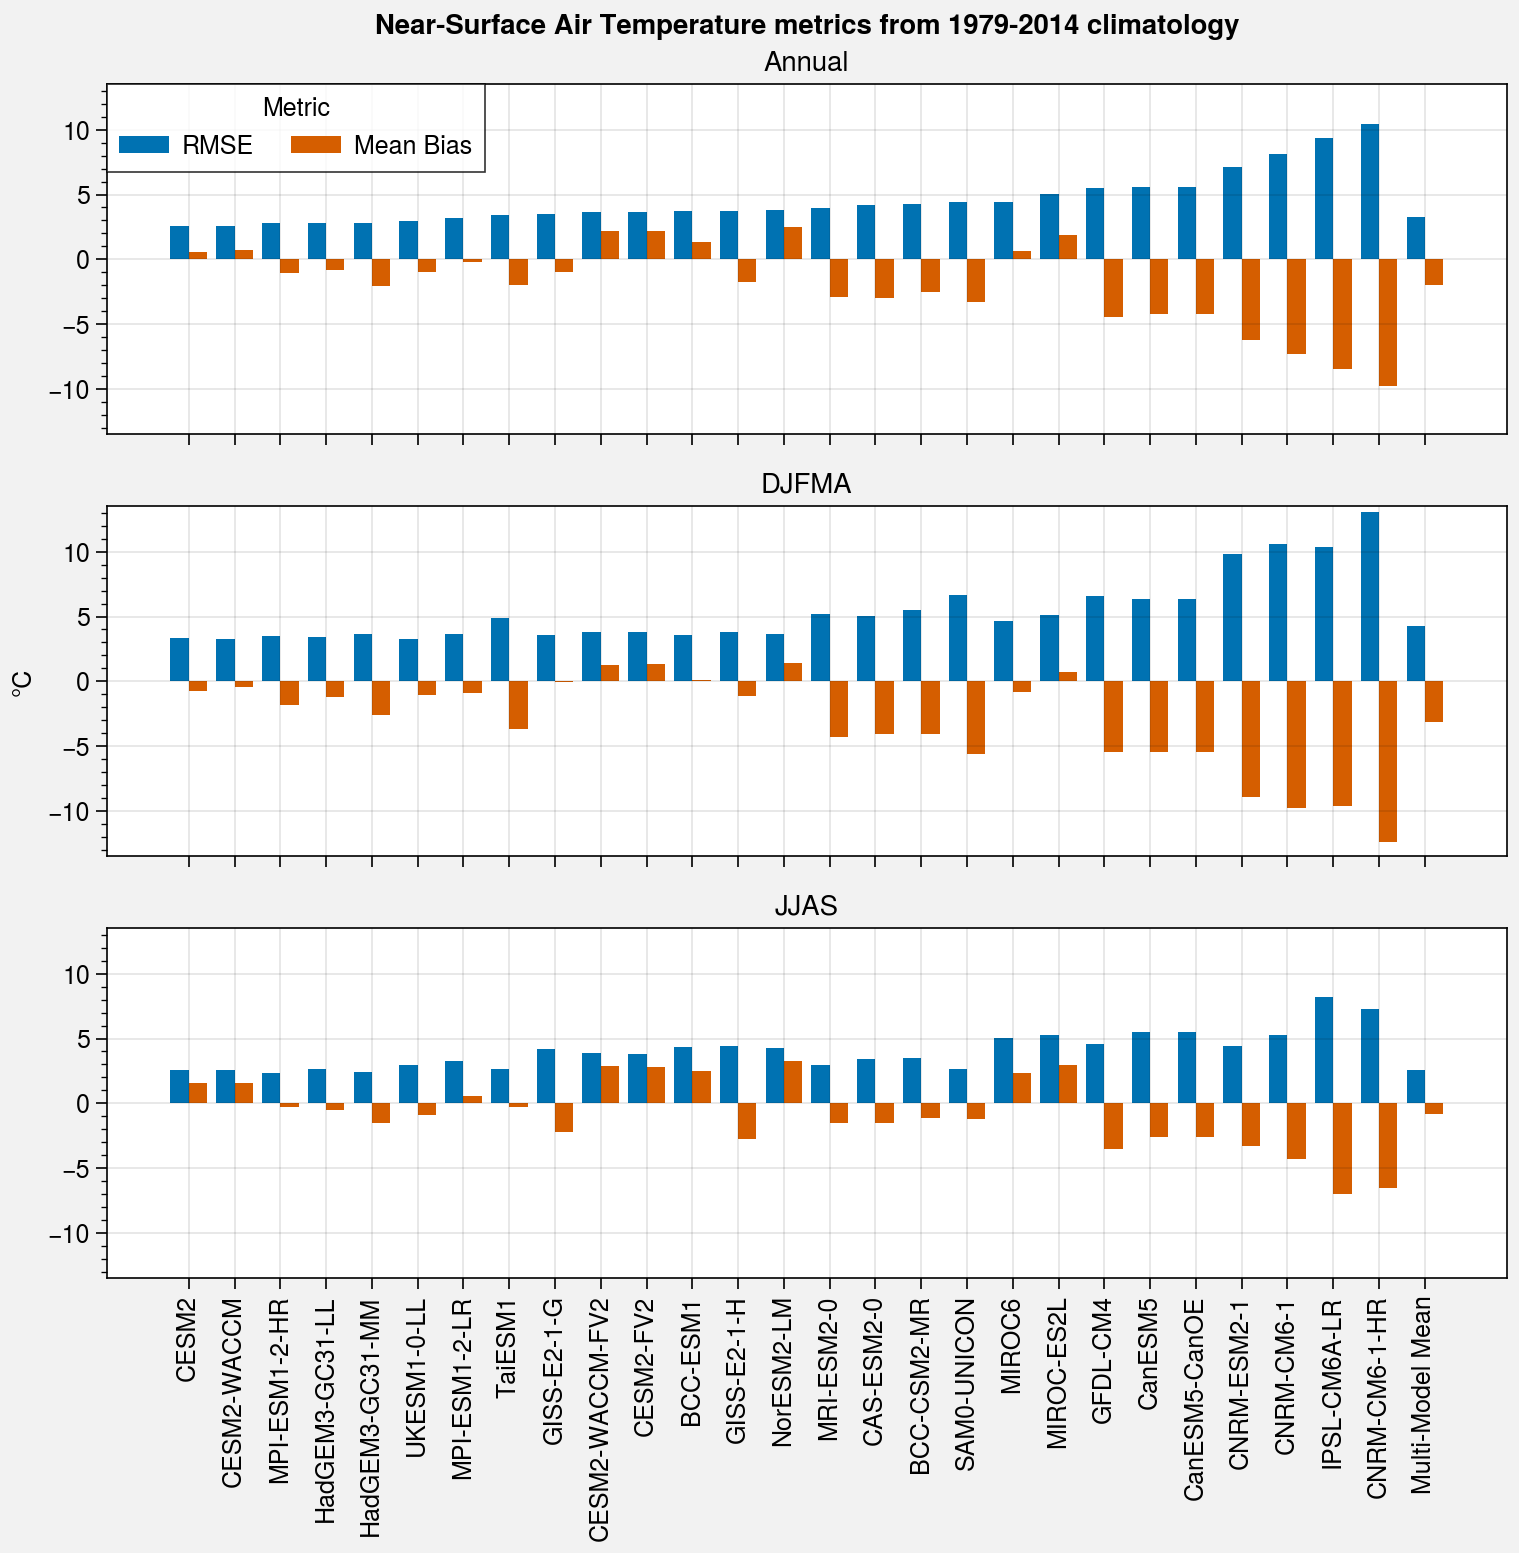

In [10]:
f, axs = plot.subplots(nrows=3, aspect=4, axwidth=7)

lim = 13.5
cycle = '538'
for i, ax in enumerate(axs):
    if i == 0:
        ax.bar(list_data[i], legend='ul', linewidth=0)
    else:
        ax.bar(list_data[i], linewidth=0)

    ax.format(
        title = multimodel_ensemble_bias_mmm.isel(season=i).season.values,
        ylim = (-lim,lim), ylabel = units, xlabel='', xrotation=90,
        suptitle = label+' metrics from '+period.start+'-'+period.stop+' climatology'
    )
    
filename = 'metrics_'+var+'_'+period.start+'-'+period.stop
# f.save('img/'+filename+'.jpg'); f.save('img/'+filename+'.png'); f.save('img/'+filename+'.pdf')

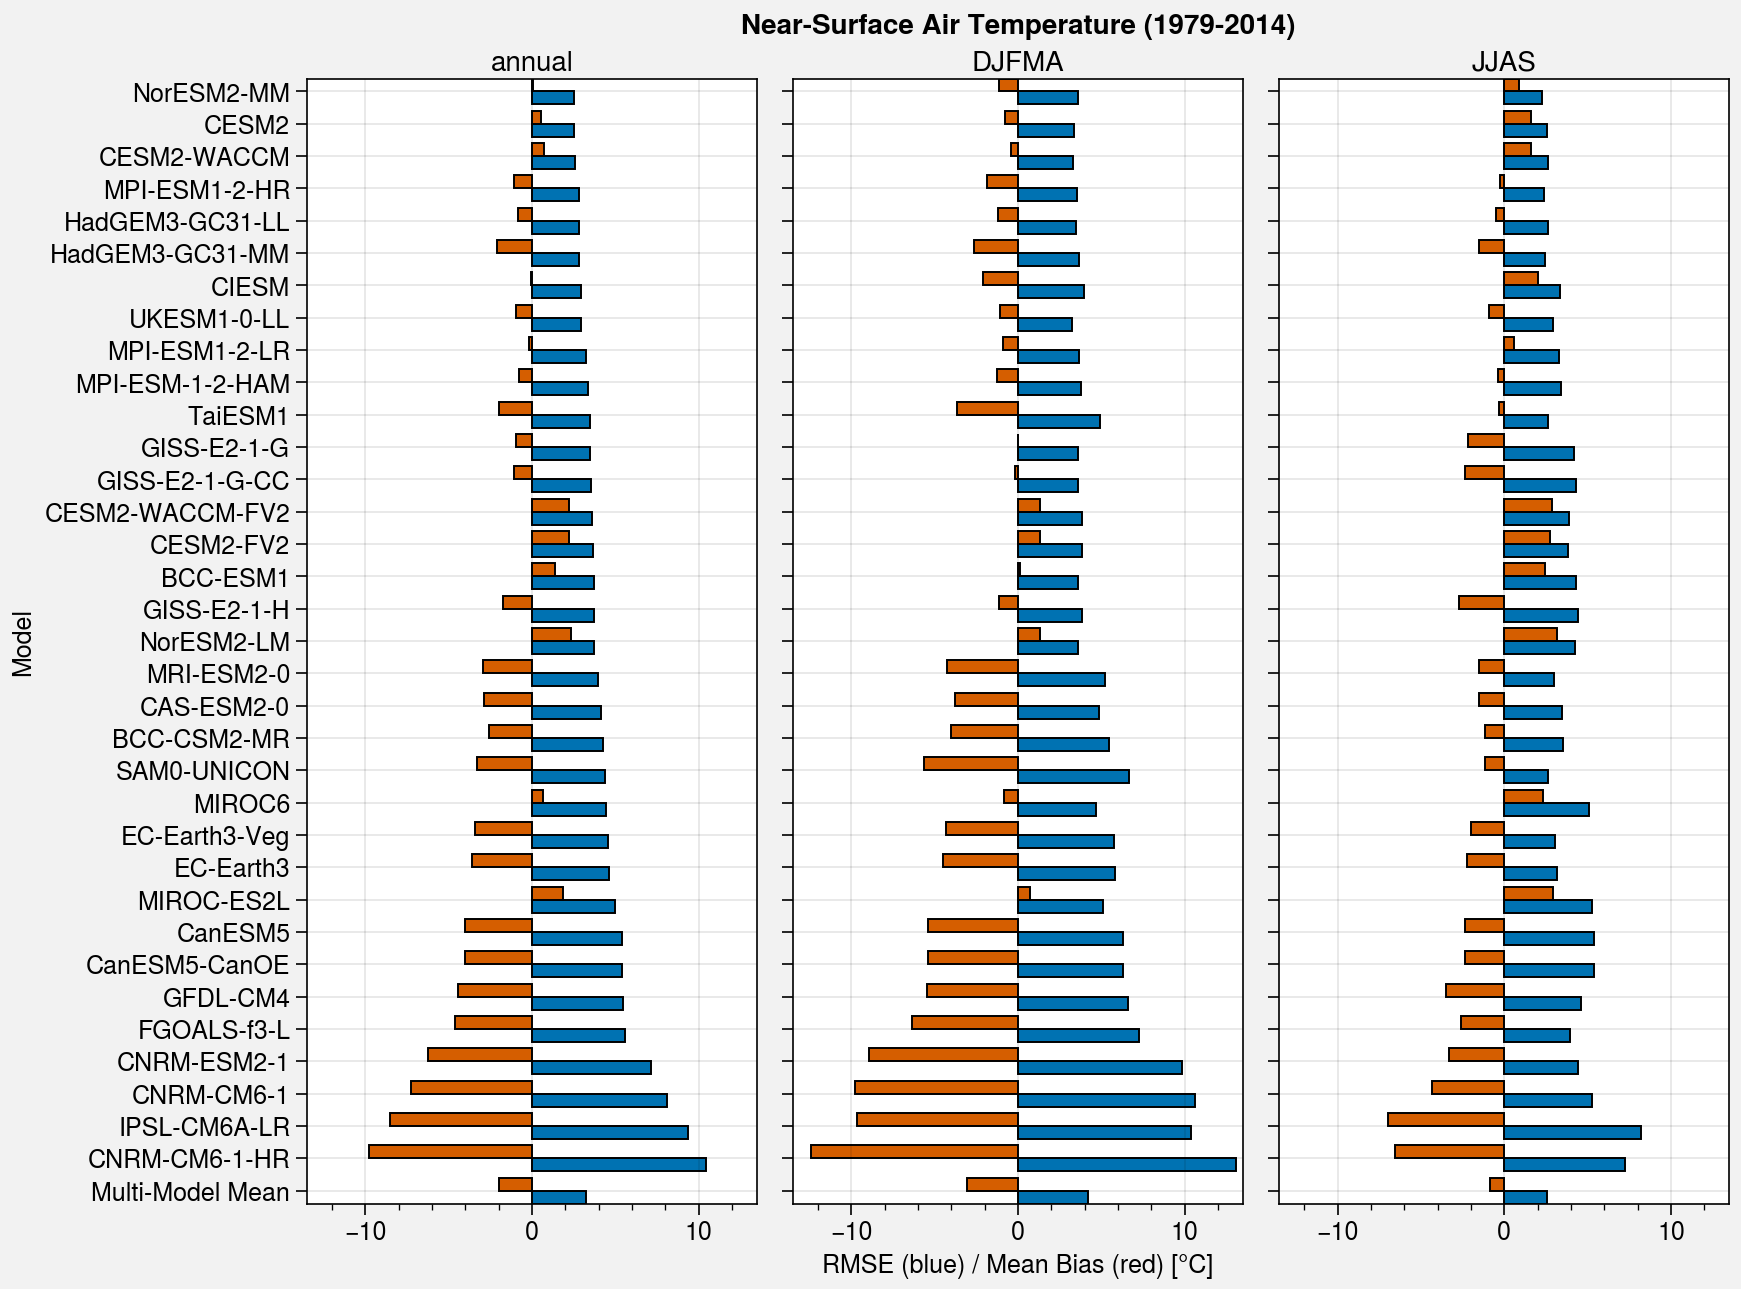

In [21]:
# f, axs = plot.subplots(ncols=3, aspect=0.4)

# lim = 13.5
# for i, ax in enumerate(axs):
#     m = ax.barh(list_data[i])

#     ax.format(
#         title = multimodel_ensemble_bias_mmm.isel(season=i).season.values,
#         xlim = (-lim,lim), xlabel = 'RMSE (blue) / Mean Bias (red) ['+units+']',
#         suptitle = label+' ('+period.start+'-'+period.stop+')'
#     )
    
# filename = 'metrics_'+var+'_'+period.start+'-'+period.stop
# # f.save('img/'+filename+'.jpg'); f.save('img/'+filename+'.png'); f.save('img/'+filename+'.pdf')

## Sorted by resolution

In [39]:
# Data shape (season, model, metric)

list_data = [None]*len(seasons)

# Keep the multimodel mean separate ([:-1])
model_sorted = multimodel_ensemble_bias_mmm.sel(season='Annual')[:-1].sortby(
    'resolution', ascending=True).model.values
model_sorted = np.append(model_sorted, multimodel_ensemble_bias_mmm.model[-1].values)

resolution = multimodel_ensemble_bias_mmm.sel(season='Annual')[:-1].sortby(
    'resolution', ascending=True).resolution
resolution = np.append(resolution, multimodel_ensemble_bias_mmm.resolution[-1].values)

model_label = [model + ' ('+res+')' for model, res in zip(model_sorted, resolution)]

for i, season in enumerate(seasons):
    data = np.ndarray(shape=(multimodel_ensemble_bias_mmm.model.size, 2))

    data[:,0] = multimodel_ensemble_bias_mmm.sel(season=season).reindex(model=model_sorted).rmse
    data[:,1] = multimodel_ensemble_bias_mmm.sel(season=season).reindex(model=model_sorted).mean_bias

    list_data[i] = pd.DataFrame(
        data, columns=pd.Index(['RMSE', 'Mean Bias'], name='Metric'),
        index=pd.Index(model_label, name='Model')
    )

# data

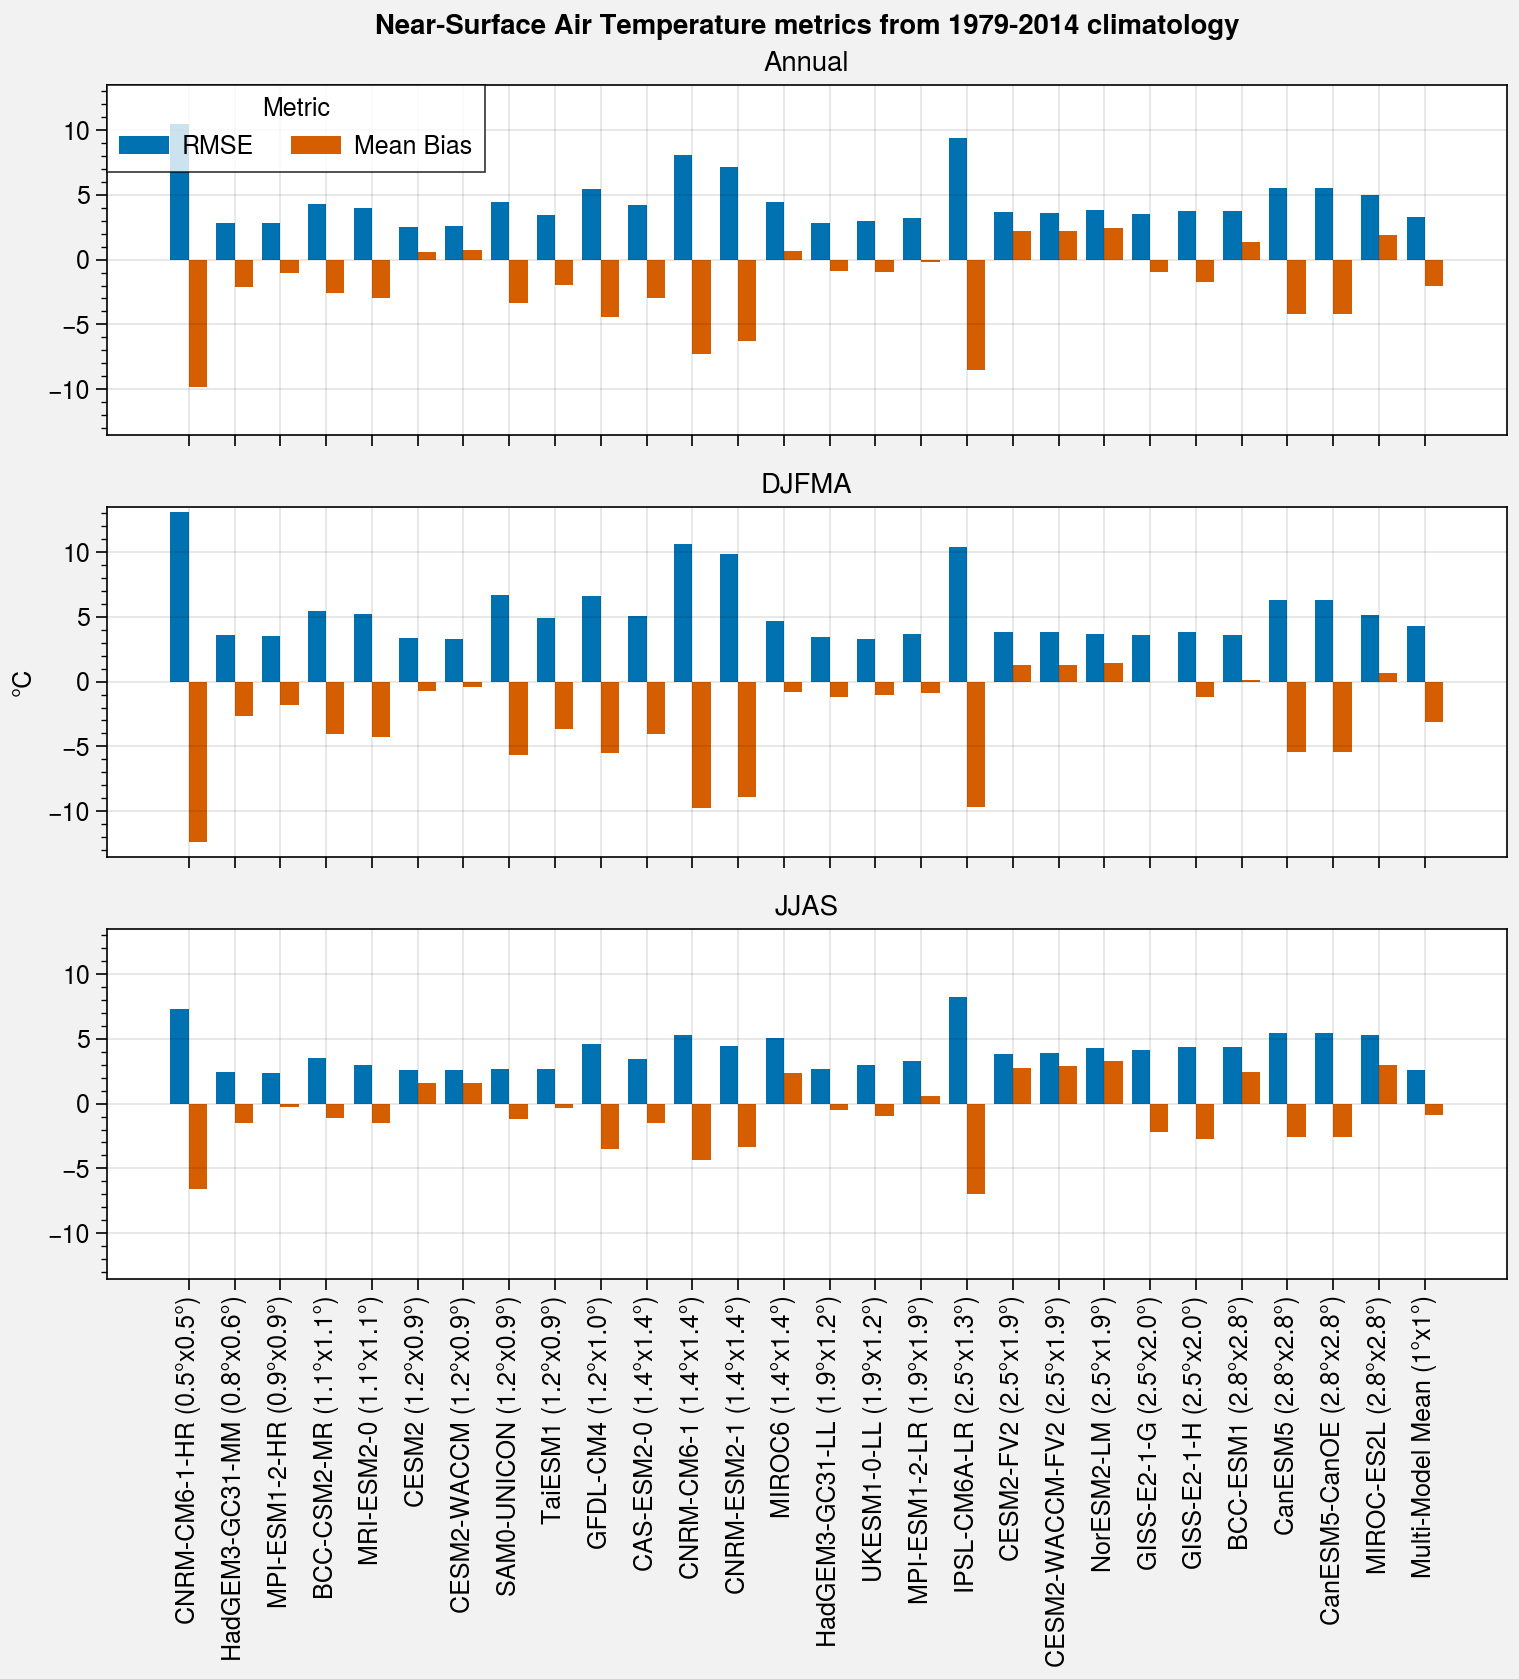

In [41]:
f, axs = plot.subplots(nrows=3, aspect=4, axwidth=7)

lim = 13.5
cycle = '538'
for i, ax in enumerate(axs):
    if i == 0:
        ax.bar(list_data[i], legend='ul', linewidth=0)
    else:
        ax.bar(list_data[i], linewidth=0)

    ax.format(
        title = multimodel_ensemble_bias_mmm.isel(season=i).season.values,
        ylim = (-lim,lim), ylabel = units, xlabel='', xrotation=90,
        suptitle = label+' metrics from '+period.start+'-'+period.stop+' climatology'
    )
    
filename = 'metrics_by_res_'+var+'_'+period.start+'-'+period.stop
# f.save('img/'+filename+'.jpg'); f.save('img/'+filename+'.png'); f.save('img/'+filename+'.pdf')

# Annual cycles

## All

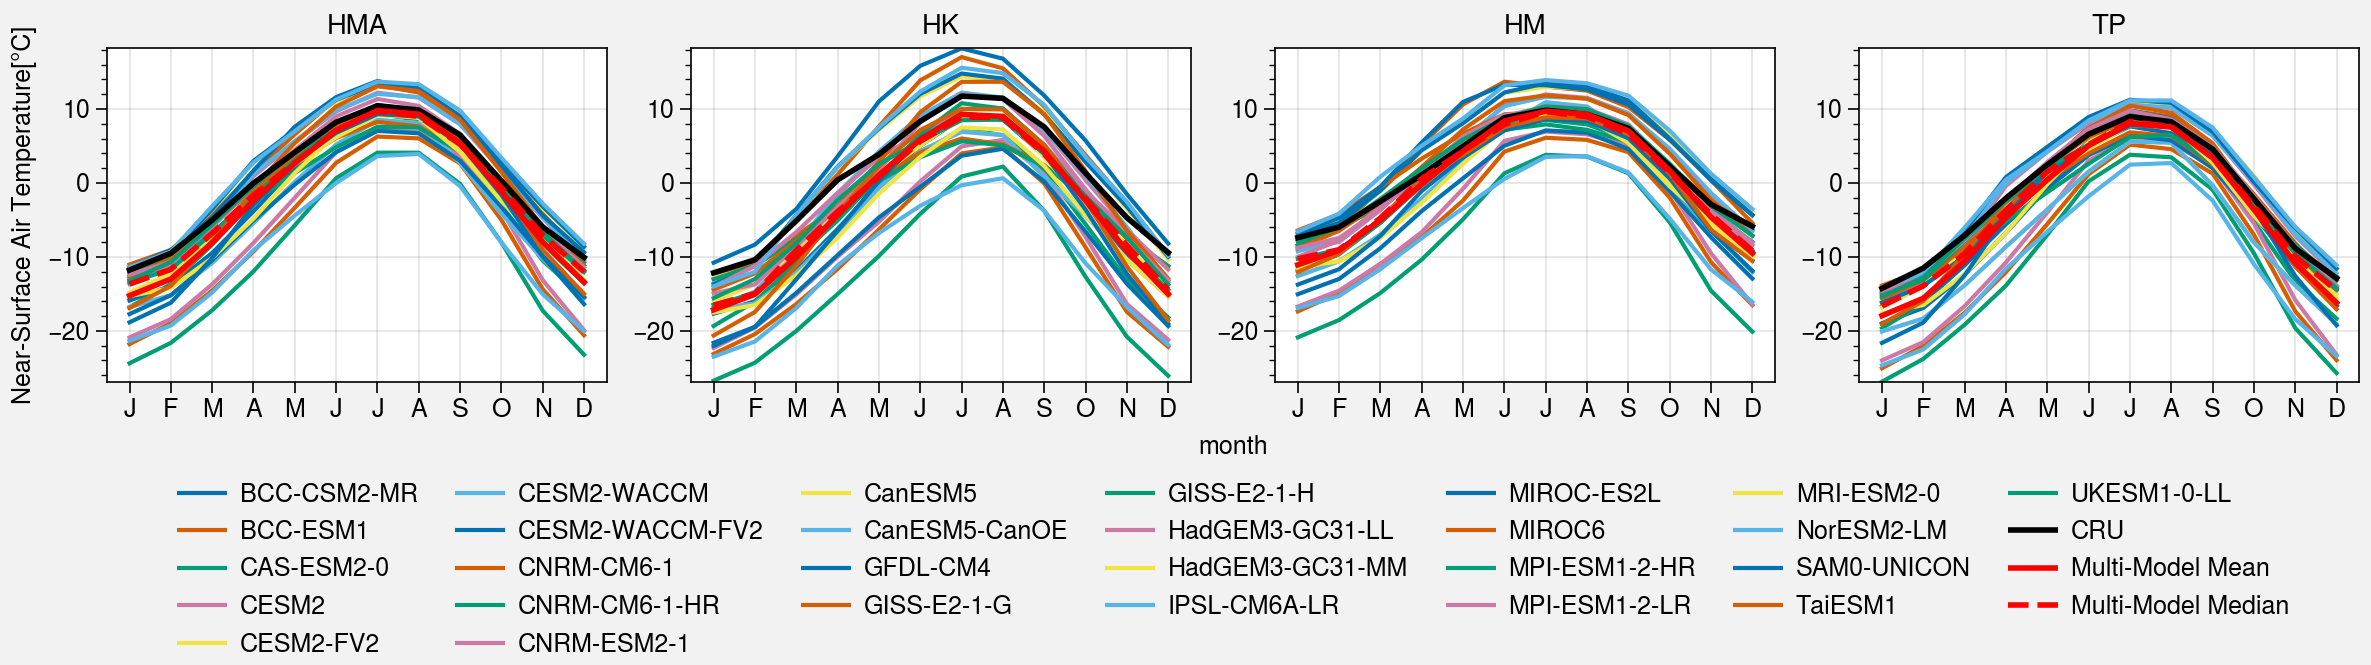

In [44]:
f, axs = plot.subplots(ncols=4, nrows=1, share=1, aspect=1.5)
hs = []

for i, ax in enumerate(axs):
    
    for model in multimodel_ensemble_ac.model.values:
        h = ax.plot(
            multimodel_ensemble_ac.isel(zone=i).sel(model=model), 
            label = str(multimodel_ensemble_ac.isel(zone=i).sel(model=model).model.values)
        )
        if i == 0:
            hs.append(h)

    # Plot observations
    h_obs = ax.plot(obs_ac_regrid_zones.isel(zone=i), label=obs_name, color='black', linewidth=2)
    if i == 0:
        hs.append(h_obs)
        
        
    # Add mean and median
    h = ax.plot(
        multimodel_ensemble_ac.isel(zone=i).mean('model'), label = 'Multi-Model Mean',
        color='red', linewidth=2
    )
    if i == 0:
        hs.append(h)
        
    h = ax.plot(
        multimodel_ensemble_ac.isel(zone=i).median('model'), label = 'Multi-Model Median',
        color='red', linewidth=2, linestyle='--'
    )
    if i == 0:
        hs.append(h)

    ax.format(
        title=zones[i],
        ylabel=label + '['+units+']', ylim=(multimodel_ensemble_ac.min(),multimodel_ensemble_ac.max()),
        xlocator='index', xformatter=['J','F','M','A','M','J','J','A','S','O','N','D'], xtickminor=False,
    )
    
f.legend(hs, loc='b', ncols=7, order='F', center=False, frame=False)

filename = 'ac_all_'+var+'_'+period.start+'-'+period.stop
# f.save('img/'+filename+'.jpg'); f.save('img/'+filename+'.png'); f.save('img/'+filename+'.pdf')

## Percentiles

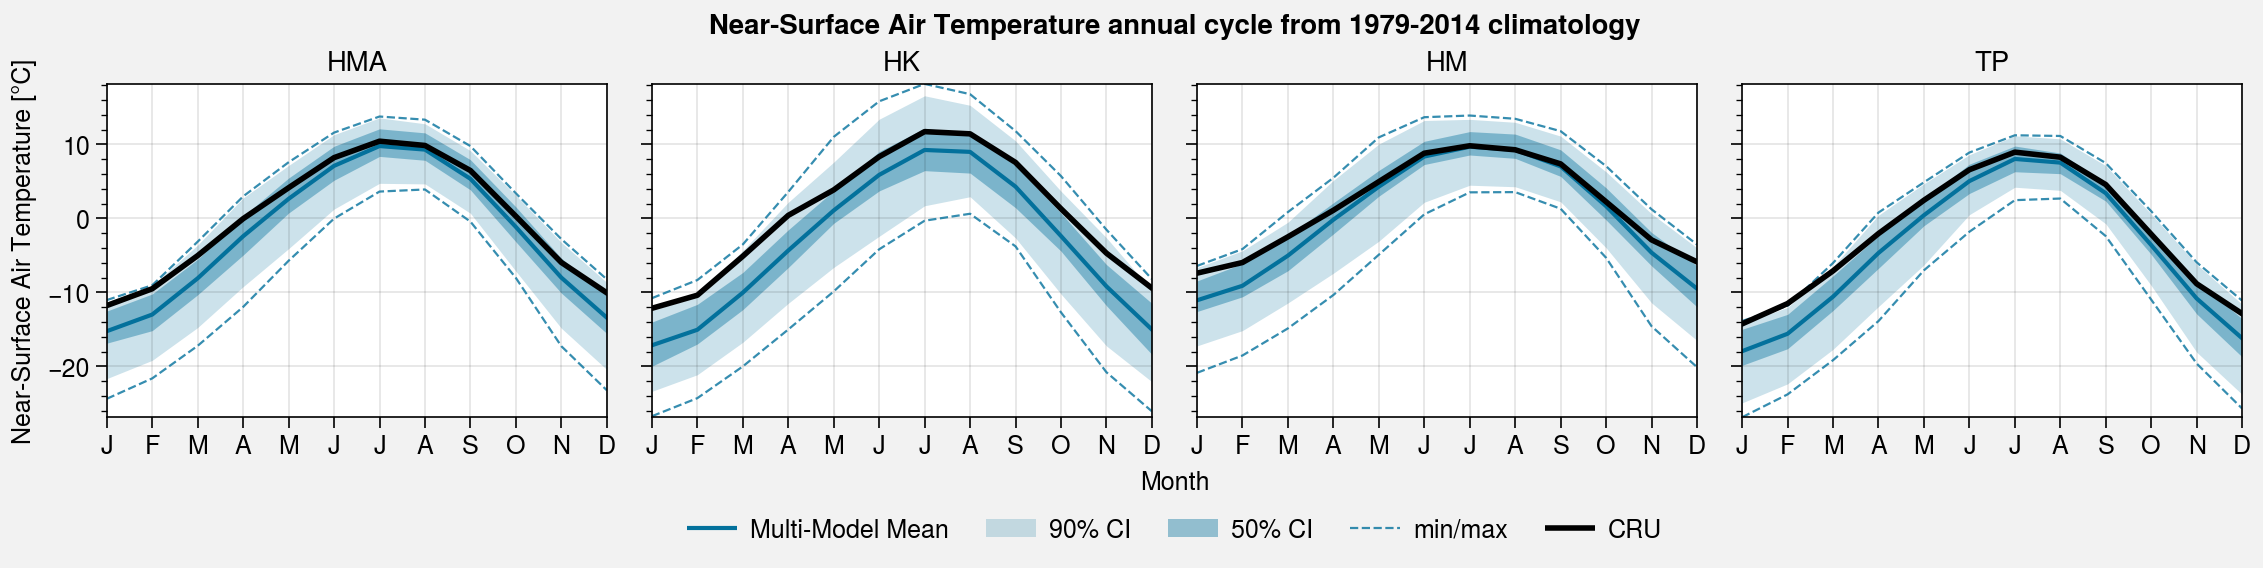

In [87]:
f, axs = plot.subplots(ncols=4, nrows=1, aspect=1.5)

color_model = 'ocean blue'
color_obs = 'black'

for i, ax in enumerate(axs):
    means = multimodel_ensemble_ac[i].mean('model')
    
    # Compute quantiles  
    shadedata = multimodel_ensemble_ac[i].quantile([0.25, 0.75], dim='model')  # dark shading
    fadedata = multimodel_ensemble_ac[i].quantile([0.05, 0.95], dim='model')  # light shading
      
    h1 = ax.plot(
        means, 
        shadedata=shadedata, fadedata=fadedata,
        shadelabel='50% CI', fadelabel='90% CI',
        label='Multi-Model Mean', color=color_model, 
    )
    
    # Add min/max
    h2 = ax.plot(
        multimodel_ensemble_ac[i].min('model'),
        label='min/max', linestyle='--', color=color_model, linewidth=0.8, alpha=0.8
    )
    ax.plot(
        multimodel_ensemble_ac[i].max('model'),
        linestyle='--', color=color_model, linewidth=0.8, alpha=0.8
    )

    # Plot observations
    h3 = ax.plot(obs_ac_regrid_zones[i], label=obs_name, color=color_obs, linewidth=2)

    ax.format(
        title=zones[i], ylabel=label + ' ['+units+']', 
        ylim=(multimodel_ensemble_ac.min(), multimodel_ensemble_ac.max()),
        xlocator='index', xformatter=['J','F','M','A','M','J','J','A','S','O','N','D'], xtickminor=False,
        xlabel='Month'
    )

f.legend([h1[0], h1[1], h1[2], h2, h3], loc='b', frame=False, ncols=7, order='F', center=False)

axs.format(suptitle=label+' annual cycle from '+period.start+'-'+period.stop+' climatology')
    
filename = 'ac_'+var+'_'+period.start+'-'+period.stop
# f.save('img/'+filename+'.jpg'); f.save('img/'+filename+'.png'); f.save('img/'+filename+'.pdf')

## STD

In [88]:
# f, axs = plot.subplots(ncols=4, nrows=1, aspect=1.5)

# color_model = 'ocean blue'
# color_obs = 'black'

# for i, ax in enumerate(axs):
#     means = multimodel_ensemble_ac[i].mean('model')
#     std = multimodel_ensemble_ac[i].std('model')
    
#     h1 = ax.plot(means, label='Multi-Model Mean', color=color_model)
    
#     h11 = ax.fill_between(
#         means.month, means-std, means+std, 
#         alpha=0.5, label='$\pm 1 \sigma$', facecolor=color_model
#     )


#     # Plot observations
#     h2 = ax.plot(obs_ac_regrid_zones[i], label=obs_name, color=color_obs, linewidth=2)

#     ax.format(
#         title=zones[i], ylabel=label.split()[-1] + ' ['+units+']', 
#         ylim=(
#             multimodel_ensemble_ac.quantile(0.05, dim='model').min(),
#             multimodel_ensemble_ac.quantile(0.95, dim='model').max()
#         ),
#         xlocator='index', xformatter=['J','F','M','A','M','J','J','A','S','O','N','D'], xtickminor=False,
#     )

# axs[0].legend([h1, h2], loc='lc', frame=False, order='F', center=False)
# axs[1].legend(h11, loc='lc', frame=False, order='F', center=False) 